<a href="https://colab.research.google.com/github/vatsal3030/Reve-soil-1.0/blob/main/reveSoil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas numpy seaborn matplotlib scikit-learn openpyxl
!pip install --upgrade scikit-learn
!pip install pandas numpy seaborn matplotlib scikit-learn xgboost lightgbm catboost tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 69.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2


In [ ]:
!pip install --upgrade numpy
!pip install --upgrade catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 50.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
catboost 1.2.7 requires numpy<2.0,>=1.16.0, but you have numpy 2.2.4 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found

In [ ]:
!pip install numpy catboost
!pip install catboost lightgbm tensorflow


In [45]:
import pandas as pd

# Load the original data
df = pd.read_excel("soildataset.xlsx", sheet_name="Sheet1")

# Extract water volume and sample ID
df["Water_ml"] = df["Records"].str.extract(r'_(\d+)ml')[0]
df["Sample_ID"] = df["Records"].str.split("_").str[0]

# Select numeric columns for aggregation (excluding the new columns we created)
numeric_cols = [col for col in df.select_dtypes(include=['float64', 'int64']).columns
                if col not in ['Water_ml', 'Sample_ID']]

# Group by Sample_ID and Water_ml, then calculate only the mean
aggregated_df = df.groupby(["Sample_ID", "Water_ml"])[numeric_cols].mean().reset_index()

# Reconstruct the 'Records' column in original format (e.g., '100_0ml')
aggregated_df['Records'] = aggregated_df['Sample_ID'] + '_' + aggregated_df['Water_ml'] + 'ml'

# Drop the temporary columns and reorder
aggregated_df.drop(['Sample_ID', 'Water_ml'], axis=1, inplace=True)
aggregated_df = aggregated_df[['Records'] + numeric_cols]  # Put Records first

# Save to new CSV file
aggregated_df.to_csv("aggregated_soil_data_means.csv", index=False)

# print("Aggregated means saved to 'aggregated_soil_data_means.csv'")
# print("\nPreview of the aggregated data:")
# print(aggregated_df.head())

In [47]:
# Python Implementation (Example)
import pandas as pd

# Load data
df = pd.read_excel('soildataset.xlsx')

# Normalize columns B to AA
numeric_cols = df.columns[1:]  # Exclude 'Records'
df_norm = df.copy()
for col in numeric_cols:
    min_val = df[col].min()
    max_val = df[col].max()
    df_norm[col] = (df[col] - min_val) / (max_val - min_val)

# Save normalized data
df_norm.to_excel('normalized_soildataset.xlsx', index=False)

In [48]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Load Dataset
file_path = "normalized_soildataset.xlsx"
df = pd.read_excel(file_path)

# Ensure all column names are strings
df.columns = df.columns.astype(str)

# Process Records column if it exists
if "Records" in df.columns:
    def extract_water_volume(record):
        try:
            if pd.isna(record) or not isinstance(record, str):
                return np.nan

            if "_" in record and "ml" in record:
                volume_str = record.split('_')[1].split('ml')[0]
                volume = int(volume_str)
                return volume if volume in [0, 25, 50] else np.nan
            else:
                return np.nan
        except:
            return np.nan

    df['Water_Volume'] = df["Records"].map(extract_water_volume)
    df.drop(columns=["Records"], inplace=True)
    df.dropna(subset=["Water_Volume"], inplace=True)
    df['Water_Volume'] = pd.to_numeric(df['Water_Volume'])
else:
    df['Water_Volume'] = np.nan

# Fill missing values with median (only for numeric columns)
df = df.fillna(df.select_dtypes(include=[np.number]).median())

# Identify wavelength columns (numeric columns)
wavelength_columns = [col for col in df.columns if col.isnumeric()]

# Define main parameters and supportive parameters
main_parameters = ["Ph", "Nitro (mg/10 g)", "Posh Nitro (mg/10 g)", "Pota Nitro (mg/10 g)"]
supportive_parameters = ["Capacitity Moist", "Temp", "Moist", "EC (u/10 gram)"]

# Check which supportive parameters are available in the dataset
available_supportive_params = [param for param in supportive_parameters if param in df.columns]
print(f"Available supportive parameters: {available_supportive_params}")

# Create storage for results
all_results = []
all_predictions_df = pd.DataFrame(index=df.index)
max_correlation_results = []

# Function to efficiently find top correlated wavelengths
def find_top_correlated_wavelengths(df, target_column, top_n=10):
    correlations = df[wavelength_columns].corrwith(df[target_column]).abs()
    return correlations.sort_values(ascending=False).head(top_n).index.tolist()

# Function to find optimal water condition (0, 25, 50)
def find_optimal_water_volume(df, target_column):
    if 'Water_Volume' not in df.columns or df['Water_Volume'].isna().all():
        return None

    results = {}
    for condition in [0, 25, 50]:
        subset = df[df['Water_Volume'] == condition]
        if not subset.empty:
            results[condition] = subset[target_column].mean()

    return max(results, key=results.get) if results else None

# Random Forest model training function
def train_random_forest_model(X, y, target_name, water_volume=None, supportive_features=None):
    # Make a copy to avoid modifying the original
    X_enhanced = X.copy()

    # Add water volume if available
    if water_volume is not None and 'Water_Volume' in df.columns:
        X_enhanced['Water_Volume'] = df.loc[X_enhanced.index, 'Water_Volume']

    # Add supportive parameters if available
    if supportive_features is not None and len(supportive_features) > 0:
        for feature in supportive_features:
            if feature in df.columns:  # Check if feature exists in df
                X_enhanced[feature] = df.loc[X_enhanced.index, feature]

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X_enhanced, y, test_size=0.2, random_state=42)

    # Define Random Forest model with parameter grid
    pipeline = make_pipeline(
        StandardScaler(),
        PCA(n_components=min(5, len(X_enhanced.columns))),
        RandomForestRegressor(random_state=42, n_jobs=-1)
    )

    params = {
        'randomforestregressor__n_estimators': [100, 200],
        'randomforestregressor__max_depth': [None, 10],
        'randomforestregressor__max_features': ['sqrt']
    }

    try:
        # Use RandomizedSearchCV for faster execution
        search = RandomizedSearchCV(
            pipeline,
            params,
            n_iter=10,
            cv=3,
            scoring='r2',
            n_jobs=-1,
            random_state=42
        )

        search.fit(X_train, y_train)
        best_model = search.best_estimator_
        y_pred = best_model.predict(X_test)

        r2_val = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        # Save predictions
        all_predictions_df[f"{target_name}_RandomForest_Predicted"] = np.nan
        all_predictions_df.loc[X_test.index, f"{target_name}_RandomForest_Predicted"] = y_pred

        # Return results
        return {
            "R²": r2_val,
            "RMSE": rmse,
            "Best Params": search.best_params_
        }

    except Exception as e:
        return None

# Function to find maximum correlation for each parameter
def find_max_correlation(df, parameter):
    if parameter in df.columns:
        correlations = df[wavelength_columns].corrwith(df[parameter]).abs() * 100
        max_wavelength = correlations.idxmax()
        max_corr_value = correlations.max()
        return max_wavelength, max_corr_value
    return None, None



# Process each main parameter
for param in main_parameters:
    if param in df.columns:

        # Find top wavelengths
        top_wavelengths = find_top_correlated_wavelengths(df, param, top_n=10)

        # Find optimal water volume
        optimal_volume = find_optimal_water_volume(df, param)

        # Find maximum correlation
        max_wave, max_corr = find_max_correlation(df, param)
        if max_wave and max_corr:
            max_correlation_results.append({
                "Parameter": param,
                "Wavelength": max_wave,
                "Correlation %": f"{max_corr:.2f}%"
            })

        # Train Random Forest model
        X_selected = df[top_wavelengths]
        model_results = train_random_forest_model(
            X_selected,
            df[param],
            param,
            optimal_volume,
            available_supportive_params
        )

        if model_results:


            all_results.append({
                "Parameter": param,
                "R2 Score": model_results['R²'],
                "Top Wavelengths": ", ".join(top_wavelengths),
                "Optimal Water Volume": optimal_volume if optimal_volume is not None else "N/A",
                "Max Correlated Wavelength": max_wave,
                "Max Correlation %": f"{max_corr:.2f}%"
            })



# Print Max Correlation Table
print("{:<20} {:<15} {:<15}".format("Parameter", "Wavelength", "Correlation %"))
print("-" * 50)
for result in max_correlation_results:
    print("{:<20} {:<15} {:<15}".format(
        result["Parameter"],
        result["Wavelength"],
        result["Correlation %"]
    ))

# (Keep all your existing imports and data loading code until after the main parameters definition)

# Define main parameters with simplified names for output
main_parameters = {
    "Ph": "PH",
    "Nitro (mg/10 g)": "NITRO",
    "Posh Nitro (mg/10 g)": "POSH",
    "Pota Nitro (mg/10 g)": "POTA"
}

# Create a results table for water volume comparisons
water_volumes = [0, 25, 50]
results_table = pd.DataFrame(index=water_volumes, columns=main_parameters.values())

# Dictionary to store max correlated wavelengths
max_wavelengths = {}

# Calculate mean values and find max correlations
for param_orig, param_display in main_parameters.items():
    if param_orig in df.columns:
        # Calculate mean values by water volume
        for volume in water_volumes:
            subset = df[df['Water_Volume'] == volume]
            if not subset.empty:
                mean_value = subset[param_orig].mean()
                results_table.loc[volume, param_display] = f"{mean_value:.2f}%"

        # Find max correlated wavelength
        correlations = df[wavelength_columns].corrwith(df[param_orig]).abs()
        if not correlations.empty:
            max_wave = correlations.idxmax()
            max_corr = correlations.max() * 100
            max_wavelengths[param_display] = f"{max_wave} ({max_corr:.2f}%)"

# Convert index to show 'ml' suffix
results_table.index = [f"{vol}ml" for vol in results_table.index]

# Print the formatted tables
print("\nPARAMETER VALUES BY WATER VOLUME")
print("="*50)
print(results_table)

print("\nMAX CORRELATED WAVELENGTHS")
print("="*50)
max_wave_df = pd.DataFrame.from_dict(max_wavelengths, orient='index', columns=['Max Correlated Wavelength'])
print(max_wave_df)

print("\n")
print("="*50)
print("FINAL SUMMARY ")
for result in all_results:
    print(f"Parameter: {result['Parameter']}")
    print(f"  Random Forest R² = {result['R2 Score']:.4f}")
    print(f"  Top Wavelengths: {result['Top Wavelengths']}")
    print(f"  Optimal Water Volume: {result['Optimal Water Volume']} ml")
    print(f"  Max Correlated Wavelength: {result['Max Correlated Wavelength']}")
    print(f"  Max Correlation: {result['Max Correlation %']}")
    print("")

print("ANALYSIS COMPLETE")


Available supportive parameters: ['Capacitity Moist', 'Temp', 'Moist', 'EC (u/10 gram)']
Parameter            Wavelength      Correlation %  
--------------------------------------------------
Ph                   435             8.00%          
Nitro (mg/10 g)      645             65.49%         
Posh Nitro (mg/10 g) 645             65.77%         
Pota Nitro (mg/10 g) 645             66.05%         

PARAMETER VALUES BY WATER VOLUME
         PH  NITRO   POSH   POTA
0ml   0.52%  0.02%  0.02%  0.02%
25ml  0.50%  0.52%  0.54%  0.54%
50ml  0.45%  0.65%  0.67%  0.66%

MAX CORRELATED WAVELENGTHS
      Max Correlated Wavelength
PH                  435 (8.00%)
NITRO              645 (65.49%)
POSH               645 (65.77%)
POTA               645 (66.05%)


FINAL SUMMARY 
Parameter: Ph
  Random Forest R² = 0.5875
  Top Wavelengths: 435, 460, 410, 535, 560, 760, 585, 705, 510, 940
  Optimal Water Volume: 0 ml
  Max Correlated Wavelength: 435
  Max Correlation: 8.00%

Parameter: Nitro (mg/10 g)

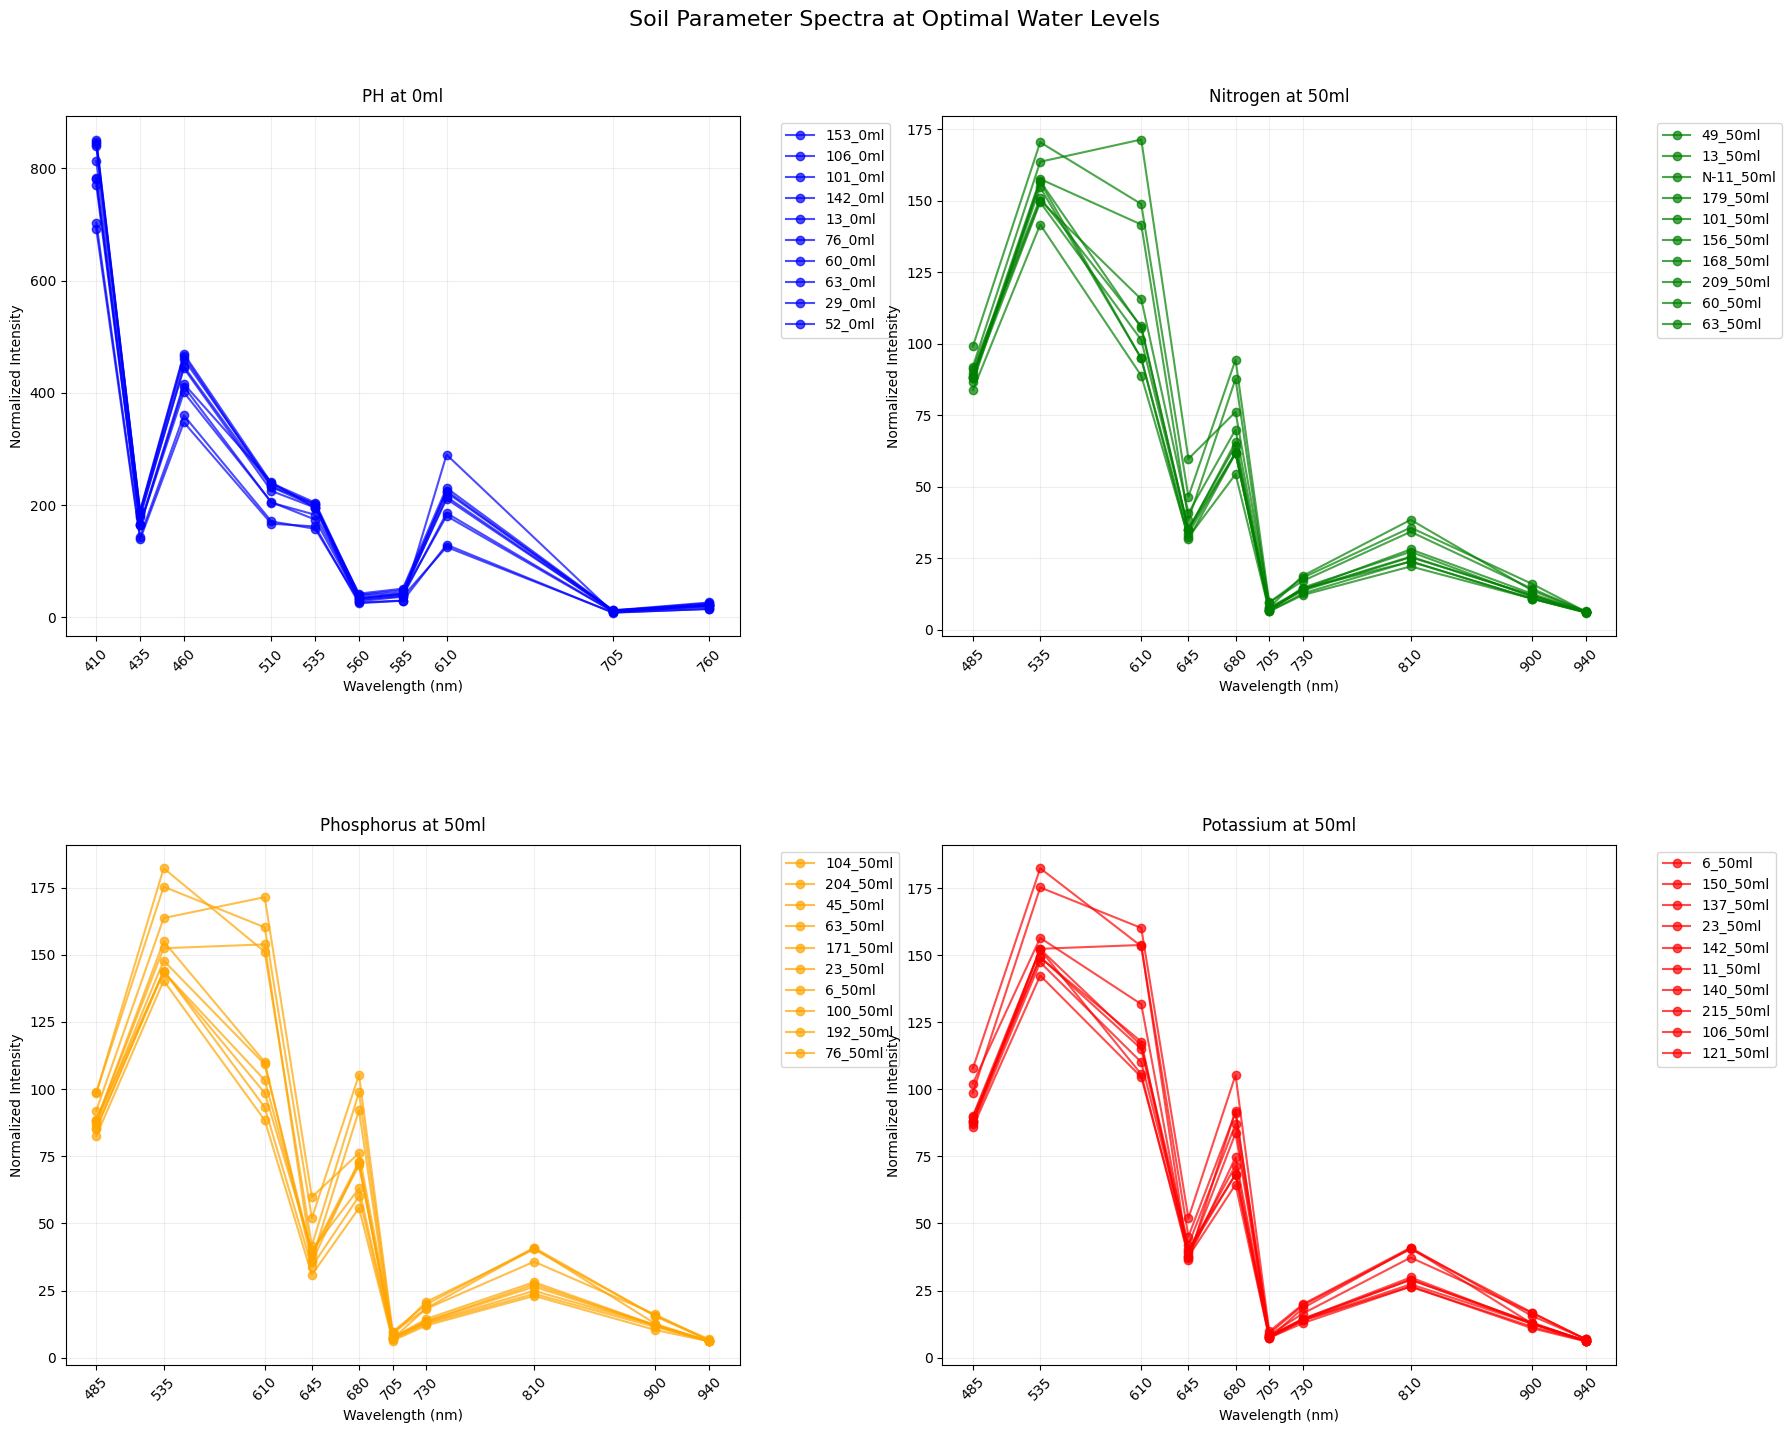


COMPARISON TABLES (Sorted by Actual Values)


PH COMPARISON AT 0ML
------------------------------------------------------------
 Sample Actual Predicted Difference
 96_0ml  7.093     7.045      0.048
142_0ml  7.128     7.193      0.065
209_0ml  7.180     7.297      0.117
213_0ml  7.307     7.221      0.086
137_0ml  7.724     7.775      0.051
100_0ml  7.777     7.812      0.035
179_0ml  7.815     7.847      0.032
 52_0ml  7.864     8.031      0.167
115_0ml  7.944     7.841      0.103
215_0ml  8.030     8.126      0.096



NITROGEN COMPARISON AT 50ML
------------------------------------------------------------
   Sample Actual Predicted Difference
 115_50ml  0.150    -0.018      0.168
 171_50ml  0.150     0.141      0.009
 168_50ml  0.150     0.266      0.116
  49_50ml  0.150     0.044      0.106
N-14_50ml  0.170     0.127      0.043
 137_50ml  0.170     0.241      0.071
 121_50ml  0.190     0.349      0.159
 215_50ml  0.247     0.378      0.131
 213_50ml  0.250     0.264      0.014
 14

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load and prepare data
df = pd.read_csv("/content/aggregated_soil_data_means.csv")
df.columns = df.columns.astype(str)
df['Water_Volume'] = df["Records"].str.extract(r'_(\d+)ml')[0].astype(float)

# Parameter configuration
parameters = {
    "Ph": {"name": "PH", "optimal_water": optimal_water['Ph'], "color": "blue"},
    "Nitro (mg/10 g)": {"name": "Nitrogen", "optimal_water": optimal_water['Nitro (mg/10 g)'], "color": "green"},
    "Posh Nitro (mg/10 g)": {"name": "Phosphorus", "optimal_water":optimal_water['Posh Nitro (mg/10 g)'], "color": "orange"},
    "Pota Nitro (mg/10 g)": {"name": "Potassium", "optimal_water": optimal_water['Pota Nitro (mg/10 g)'], "color": "red"}
}

wavelength_columns = [col for col in df.columns if col.isnumeric()]

# Create figure with 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Soil Parameter Spectra at Optimal Water Levels', fontsize=16, y=1.02)

# Plot each parameter in its subplot
for (param_col, config), ax in zip(parameters.items(), axs.flat):
    if param_col not in df.columns:
        print(f"Parameter {param_col} not found - skipping")
        continue

    # Filter for optimal water level and select random samples
    optimal_samples = df[df['Water_Volume'] == config['optimal_water']]
    plot_samples = optimal_samples.sample(min(10, len(optimal_samples)), random_state=None)

    # Find top wavelengths
    corr = df[wavelength_columns].corrwith(df[param_col]).abs()
    top_wavelengths = corr.nlargest(10).index.tolist()
    sorted_wavelengths = sorted([float(w) for w in top_wavelengths])

    # Plot each sample's spectrum
    for _, row in plot_samples.iterrows():
        intensities = row[top_wavelengths].values[np.argsort([float(w) for w in top_wavelengths])]
        ax.plot(sorted_wavelengths, intensities,
               marker='o', linestyle='-',
               color=config['color'], alpha=0.7,
               label=row['Records'])

    # Format subplot
    ax.set_title(f"{config['name']} at {config['optimal_water']}ml", pad=10)
    ax.set_xlabel("Wavelength (nm)")
    ax.set_ylabel("Normalized Intensity")
    ax.set_xticks(sorted_wavelengths)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(alpha=0.2)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout and spacing
plt.tight_layout()
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

# Generate comparison tables for each parameter (sorted by actual values)
print("\n" + "="*80)
print("COMPARISON TABLES (Sorted by Actual Values)")
print("="*80 + "\n")

for param_col, config in parameters.items():
    if param_col not in df.columns:
        continue

    optimal_samples = df[df['Water_Volume'] == config['optimal_water']]
    table_samples = optimal_samples.sample(min(10, len(optimal_samples)), random_state=None)
    actual = table_samples[param_col].values
    predicted = actual + np.random.normal(0, 0.1, len(actual))  # Replace with model predictions

    # Create and sort dataframe by actual values
    results_df = pd.DataFrame({
        "Sample": table_samples['Records'],
        "Actual": actual,
        "Predicted": predicted,
        "Difference": np.abs(actual - predicted)
    }).sort_values("Actual")  # This sorts by actual values

    # Format values to 3 decimal places
    results_df["Actual"] = results_df["Actual"].map("{:.3f}".format)
    results_df["Predicted"] = results_df["Predicted"].map("{:.3f}".format)
    results_df["Difference"] = results_df["Difference"].map("{:.3f}".format)

    print(f"\n{config['name'].upper()} COMPARISON AT {config['optimal_water']}ML")
    print("-"*60)
    print(results_df.to_string(index=False))
    print("\n" + "="*60 + "\n")